In [1]:
import Pkg
Pkg.activate("scripts") # Change this to "." incase your "scripts" is already your working directory

  Activating project at `C:\Users\adity\Julia Files\TUM Masters\Modelling and Machine Learning of Dynamical Systems in Julia\project\scripts`


In [2]:
using OrdinaryDiffEq, Flux, Optimisers, ParameterSchedulers, Random

# Not registered packages, add them manually (see comment in the Readme.md)
using LVModels, NODEData

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\adity\.julia\packages\Flux\3711C\ext\FluxCUDAExt\FluxCUDAExt.jl:10


In [3]:
Random.seed!(1234) # We set a random seed to have reproducible results

TaskLocalRNG()

In [4]:
# Define the 4D Lotka-Volterra model
function lotka_volterra_4d!(du, u, p, t)
    x, y, z, w = u
    α, β, γ, δ, η, ζ, κ, σ, λ, μ = p  
    
    du[1] = α*x - β*x*y
    du[2] = -γ*y + δ*x*y - η*y*z
    du[3] = -ζ*z + κ*y*z - σ*z*w
    du[4] = -λ*w + μ*z*w
end

# Model parameters and initial conditions
p = Float32.([1.0, 0.1, 1.0, 0.5, 0.1, 1.0, 0.5, 0.1, 1.0, 0.05])
tspan, dt = (0f0, 1000f0), 0.1f0
u0 = Float32.([6.5, 9.5, 19.5, 20.5])

# Solve the ODE
sol = solve(ODEProblem(lotka_volterra_4d!, u0, tspan, p), Tsit5(), saveat=dt)

# Create dataset with randomly missing values
t, X_sparse, mask = sparsify_data(sol) # 0% missing values for species w
train, valid = NODEDataloader(X_sparse, t, 2; valid_set=0.2)

(NODEData{Matrix{Float32},Int64} with 8000 batches with length 2, NODEData{Matrix{Float32},Int64} with 1999 batches with length 2)

In [5]:
# Define neural ODE model
N_weights = 128
U_nn = Chain(Dense(4, N_weights, swish), Dense(N_weights, N_weights, swish), Dense(N_weights, 4))
θ, U_re = Flux.destructure(U_nn)
p_ln = LearnableParams(θ, Float32[0.0]) # Learnable decay parameter

function neural_ode(u, p_ln::LearnableParams, t)
    x, y, z, w = u
    U = U_re(p_ln.θ)(u)
    [1.0f0 * x + U[1], -1.0f0 * y + U[2], -1.0f0 * z + U[3], -1.0f0 * w + U[4]]
end

model = NDE(ODEProblem(neural_ode, u0, (0f0, dt), p_ln); reltol=1e-5, dt=dt)

NDE{LearnableParams{Vector{Float32}}, ODEProblem{Vector{Float32}, Tuple{Float32, Float32}, false, LearnableParams{Vector{Float32}}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(neural_ode), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, Base.Pairs{Symbol, AbstractFloat, Tuple{Symbol, Symbol}, @NamedTuple{reltol::Float64, dt::Float32}}}(LearnableParams{Vector{Float32}}(Float32[0.18227568, 0.007618222, -0.11553465, 0.1064806, 0.10857654, 0.02240077, -0.09112908, -0.17762175, 0.083783895, 0.010999298  …  0.07922067, -0.008206616, 0.20089415, -0.1624351, -0.10757296, 0.06698284, 0.0, 0.0, 0.0, 0.0], Float32[0.0]), ODEProblem{Vector{F

In [6]:
# Training setup
opt_state = Optimisers.setup(Optimisers.Adam(1f-3), model)

τ_min, τ_max, epochs = 2, 2, 20
NN_train, NN_valid = min(100, length(train)), min(100, length(valid))
scheduler = CosAnneal(1f-3, 0f0, epochs, false)

CosAnneal{Float32, Int64}(0.001f0, 0.0f0, 20, false)

In [7]:
# Training loop 
Train = false
if Train
    println("Training started...")
    for i_τ in τ_min:τ_max
        train_τ = NODEDataloader(X_sparse, t, i_τ)
        @info "Batch size = $(i_τ)"

        for epoch in 1:epochs
            η = Float32(scheduler(epoch))
            Optimisers.adjust!(opt_state, η)

            for (batch_t, batch_data) in train_τ
                batch_mask = get_mask_for_batch(batch_t, mask, t[1], dt)
                Flux.train!(model, [(batch_t, batch_data)], opt_state) do m, bt, bd
                    loss(m, (bt, bd), bd, batch_mask)
                end
            end

            train_loss = mean([loss(model, train[i], train[i][2], get_mask_for_batch(train[i][1], mask, t[1], dt)) for i in 1:NN_train])
            valid_loss = mean([loss(model, valid[i], valid[i][2], get_mask_for_batch(valid[i][1], mask, t[1], dt)) for i in 1:NN_valid])
            @printf("Epoch %3d | LR: %.2e | Train Loss: %.4f | Valid Loss: %.4f\n", epoch, η, train_loss, valid_loss)

        end
    end
end

In [8]:
# Prediction for the trained NODE
@load "trained NODEs\\lv_4d_scenario1.jld2" model # Load the trained model; path relative to scripts

train_70 = NODEDataloader(X_sparse, t, 70) # Training batches of size 70 for L2 error plot
mask1 = X_sparse[4, :] .!= 0  # Logical mask for nonzero elements
# Using β = p[2], δ = p[4], η = p[5], κ = p[7], σ = p[8], and μ = p[10]
U_truth1 = -p[2] .* X_sparse[1, mask1] .* X_sparse[2, mask1]
U_truth2 = p[4] .* X_sparse[1, mask1] .* X_sparse[2, mask1] .- p[5] .* X_sparse[2, mask1] .* X_sparse[3, mask1]
U_truth3 = p[7] .* X_sparse[2, mask1] .* X_sparse[3, mask1] .- p[8] .* X_sparse[3, mask1] .* X_sparse[4, mask1]
U_truth4 = p[10] .* X_sparse[3, mask1] .* X_sparse[4, mask1]
U_truth = vcat(U_truth1', U_truth2', U_truth3', U_truth4')

plt_traj, plt_interaction, plt_l2_error, plt_re = plot_model_performance(sol, t, X_sparse, train_70, model, U_re, U_truth, mask, dt)

(Plot{Plots.GRBackend() n=8}, Plot{Plots.GRBackend() n=8}, Plot{Plots.GRBackend() n=1}, Plot{Plots.GRBackend() n=8})

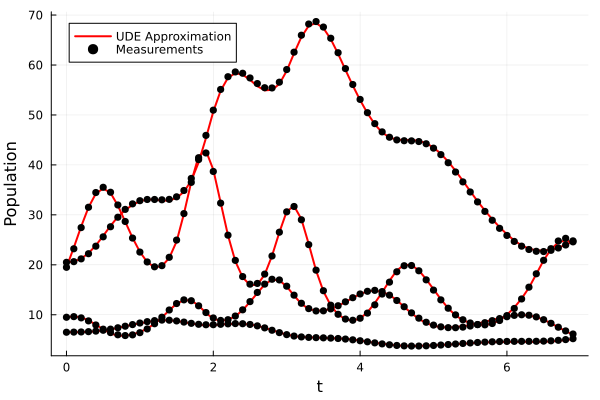

In [9]:
display(plt_traj)

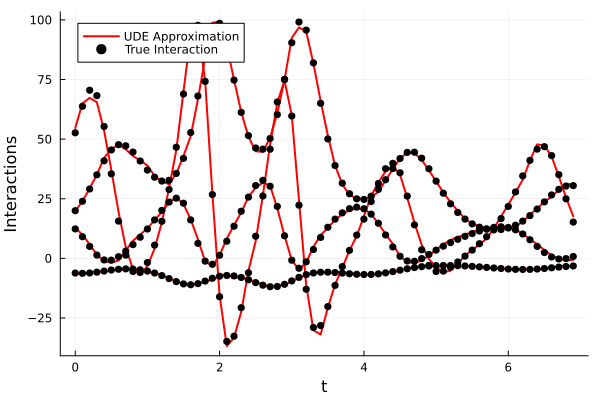

In [10]:
display(plt_interaction)

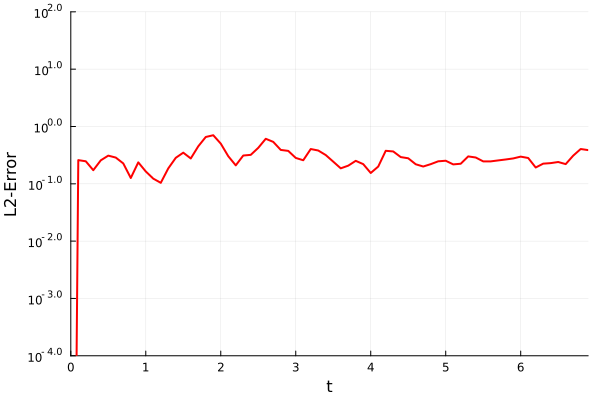

In [11]:
display(plt_l2_error)

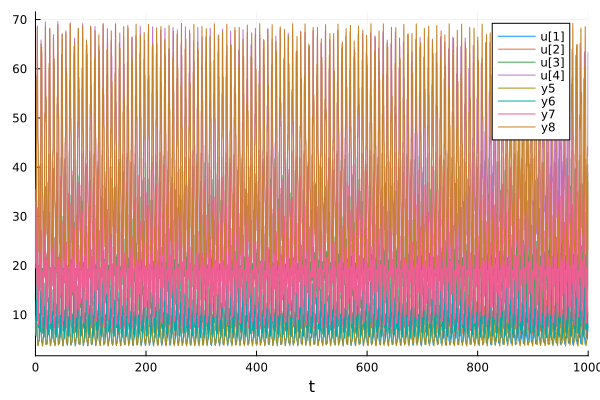

In [12]:
display(plt_re)

In [13]:
# Extract learned interactions from the neural network
mlp = U_re(model.p.θ)
dx = mlp(X_sparse)

4×10001 Matrix{Float32}:
 -6.21041  -6.4811   -6.17072  -5.65949  …   -5.88439   -7.42484   -7.33113
 12.8087    9.89462   5.86177   1.48248      11.3372    17.0482    20.5319
 54.6548   64.9727   67.3104   65.4902      -41.5341   -29.9471   -16.2308
 19.7835   23.9552   29.3386   35.152        80.5327    63.6286    51.4016

In [14]:
# Perform symbolic regression using the trained NODE
hall_of_fame, pareto_frontiers = perform_symbolic_regression(X_sparse, dx)
display(pareto_frontiers[1][3].tree) 
display(pareto_frontiers[2][3].tree) 
display(pareto_frontiers[3][3].tree) 
display(pareto_frontiers[4][3].tree) 

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\adity\.julia\packages\ProgressMeter\kVZZH\src\ProgressMeter.jl:594
Evolving for 100 iterations... 100%|█████████████████████| Time: 0:19:57


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           3.217e+02  1.594e+01  y = x₄
3           2.220e+02  1.855e-01  y = x₃ * 2.0209
5           1.833e+00  2.398e+00  y = (x₃ * 0.050516) * x₄
7           1.582e+00  7.366e-02  y = ((x₃ + 0.61065) * x₄) * 0.049248
9           1.454e+00  4.215e-02  y = (((x₂ * 0.056922) + x₃) * 0.049217) * x₄
11          1.437e+00  5.939e-03  y = (x₃ + (x₂ * 0.053658)) * ((x₄ * 0.049726) + -0.019399)
13          1.436e+00  2.469e-04  y = (x₄ + -0.4223) * (((x₃ + 0.064096) * 0.049728) - (x₂ *...
                                       -0.0024544))
15          1.436e+00  5.937e-05  y = ((x₄ + -0.32414) * (((x₃ * 0.049616) - (x₂ * -0.002425...
                                      3)) + 0.0061385)) + -0.11839
17          1.393e+00  1.504e-02  y = (((x₃ * 0.049234) * x₄) - (x₄ * -0.040513)) + ((-0.212...
                                      35 - (x₂ * -0.01492

[ Info: Final population:
[ Info: Results saved to:


(x2 * x1) * -0.10151705

(x1 * 5.054239) - x3

(x2 * 6.134513) - x4

(x3 * 0.050515667) * x4